# CS-GY 6513 Final Project - Data Analysis

## Macro-level Economic Data Analysis

### Preparation

First, we want to import all the libraries used.
(Notice that since for this part of analysis I run PySpark on my own PC, I use findspark package)

In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np
import pandas as pd
import os
import math
import time
import csv
import matplotlib.pyplot as plt
import pyspark

In [3]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation

We then use the preprocessed data covid_analysis.csv to do data analysis.

In [4]:
input_file = open('covid_analysis.csv', newline='')
reader_analysis = csv.reader(input_file, delimiter=',')
count = 0
for row in reader_analysis:
    if count > 10:
        break
    count = count + 1
    print(', '.join(row))

Start Date, Cases at Start, Case Increase, Dow Jones Adjusted Close, Dow Jones Difference, Gasoline Price, Unemployment Initial Claims, Grocery and Pharmacy Mobility, Residential Mobility, Retail and Recreation Mobility
2020-02-17, 25, 18, 28992.41, -3583.05, 2.518, 220000, 0.43, 0.71, 3.57
2020-02-24, 43, 61, 25409.36, 455.42, 2.555, 217000, 3.71, -0.71, 7.71
2020-03-02, 104, 644, 25864.78, -2679.16, 2.514, 211000, 6.71, -1.0, 8.43
2020-03-09, 748, 3759, 23185.62, -4011.64, 2.468, 282000, 14.57, 1.57, 1.86
2020-03-16, 4507, 38998, 19173.98, 2462.8, 2.343, 3307000, 5.71, 12.29, -27.71
2020-03-23, 43505, 120450, 21636.78, -584.25, 2.217, 6867000, -15.43, 17.57, -42.0
2020-03-30, 163955, 205102, 21052.53, 2666.84, 2.103, 6615000, -14.71, 18.57, -42.29
2020-04-06, 369057, 214961, 23719.37, 523.12, 2.022, 5237000, -16.71, 19.29, -45.71
2020-04-13, 584018, 200973, 24242.49, -467.22, 1.951, 4442000, -16.43, 18.43, -41.71
2020-04-20, 784991, 209202, 23775.27, -51.58, 1.91, 3867000, -14.43, 17

We extract the data that we need from the preprocessed data file into vectors.

In [5]:
analysis_idx = ['Start Date', 'Cases at Start', 'Case Increase', 'Dow Jones Adjusted Close', 'Dow Jones Difference', 'Gasoline Price', 'Unemployment Initial Claims', 'Grocery and Pharmacy Mobility', 'Residential Mobility', 'Retail and Recreation Mobility']
input_file.seek(0)
start_date = []
case_total = []
case_increase = []
dow_close = []
dow_diff = []
gaso = []
unemployment = []
grocery_pharmacy = []
residential = []
retail_recreation = []
collection = []


for row in reader_analysis:
    if row[0] == 'Start Date':
        continue
    start_date.append(row[analysis_idx.index('Start Date')])
    case_total.append(float(row[analysis_idx.index('Cases at Start')]))
    case_increase.append(float(row[analysis_idx.index('Case Increase')]))
    dow_close.append(float(row[analysis_idx.index('Dow Jones Adjusted Close')]))
    dow_diff.append(float(row[analysis_idx.index('Dow Jones Difference')]))
    gaso.append(float(row[analysis_idx.index('Gasoline Price')]))
    unemployment.append(float(row[analysis_idx.index('Unemployment Initial Claims')]))
    grocery_pharmacy.append(float(row[analysis_idx.index('Grocery and Pharmacy Mobility')]))
    residential.append(float(row[analysis_idx.index('Residential Mobility')]))
    retail_recreation.append(float(row[analysis_idx.index('Retail and Recreation Mobility')]))
    collection.append([Vectors.dense([float(row[analysis_idx.index('Cases at Start')]),
                                      float(row[analysis_idx.index('Case Increase')]),
                                      float(row[analysis_idx.index('Dow Jones Adjusted Close')]),
                                      float(row[analysis_idx.index('Dow Jones Difference')]),
                                      float(row[analysis_idx.index('Gasoline Price')]),
                                      float(row[analysis_idx.index('Unemployment Initial Claims')]),
                                      float(row[analysis_idx.index('Grocery and Pharmacy Mobility')]),
                                      float(row[analysis_idx.index('Residential Mobility')]),
                                      float(row[analysis_idx.index('Retail and Recreation Mobility')])])])

In [6]:
for i in range(len(start_date)):
    start_date[i] = start_date[i][5:]

### Plotting

We plot COVID-19 total cases and case increase as line chart.

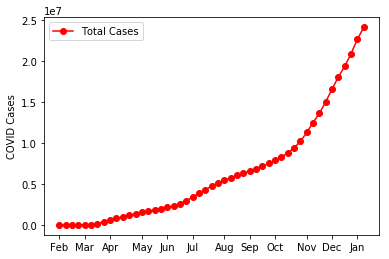

In [74]:
plt.plot(start_date, case_total,'o-',color = 'r',label="Total Cases")
plt.xticks([0,4,8,13,17,21,26,30,34,39,43,47], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec','Jan'])
plt.ylabel("COVID Cases")
plt.legend(loc = "best")
plt.show()

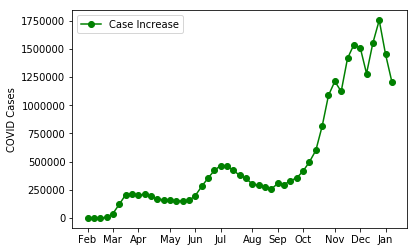

In [75]:
plt.plot(start_date, case_increase,'o-',color = 'g',label="Case Increase")
plt.xticks([0,4,8,13,17,21,26,30,34,39,43,47], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec','Jan'])
plt.ylabel("COVID Cases")
plt.legend(loc = "best")
plt.show()

We also plot COVID-19 total cases, case increase, and other economic indices up till July 2020, since our survey data is around April, May and June.

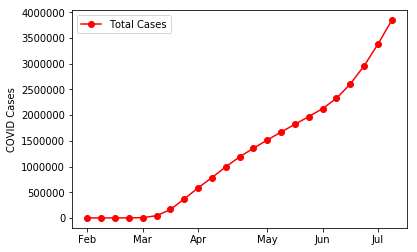

In [32]:
plt.plot(start_date[0:23], case_total[0:23],'o-',color = 'r',label="Total Cases")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("COVID Cases")
plt.legend(loc = "best")
plt.show()

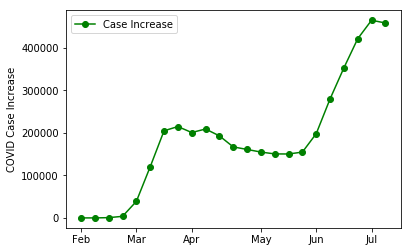

In [45]:
plt.plot(start_date[0:23], case_increase[0:23],'o-',color = 'g',label="Case Increase")#o-:圆形
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("COVID Case Increase")
plt.legend(loc = "best")
plt.show()

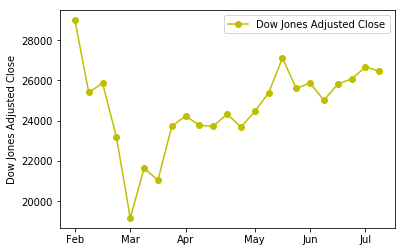

In [55]:
plt.plot(start_date[0:23], dow_close[0:23],'o-',color = 'y',label="Dow Jones Adjusted Close")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("Dow Jones Adjusted Close")
plt.legend(loc = "best")
plt.show()

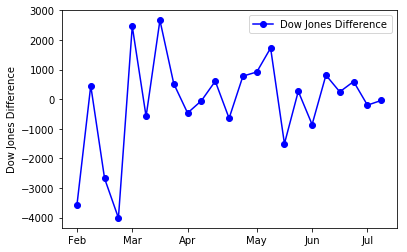

In [56]:
plt.plot(start_date[0:23], dow_diff[0:23],'o-',color = 'b',label="Dow Jones Difference")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("Dow Jones Difference")
plt.legend(loc = "best")
plt.show()

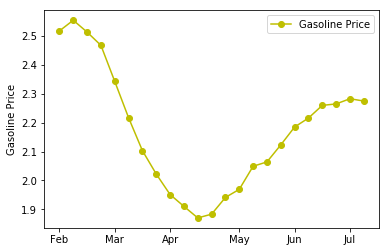

In [60]:
plt.plot(start_date[0:23], gaso[0:23],'o-',color = 'y',label="Gasoline Price")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("Gasoline Price")
plt.legend(loc = "best")
plt.show()

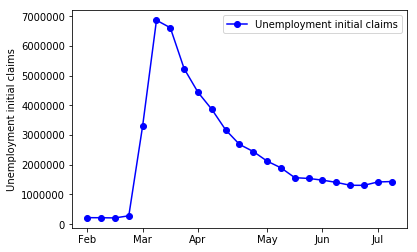

In [58]:
plt.plot(start_date[0:23], unemployment[0:23],'o-',color = 'b',label="Unemployment initial claims")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("Unemployment initial claims")
plt.legend(loc = "best")
plt.show()

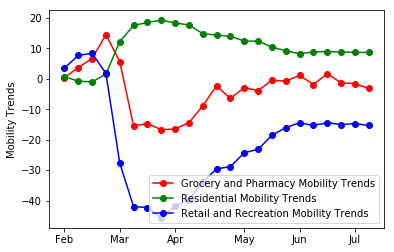

In [62]:
plt.plot(start_date[0:23], grocery_pharmacy[0:23],'o-',color = 'r',label="Grocery and Pharmacy Mobility Trends")
plt.plot(start_date[0:23], residential[0:23],'o-',color = 'g',label="Residential Mobility Trends")
plt.plot(start_date[0:23], retail_recreation[0:23],'o-',color = 'b',label="Retail and Recreation Mobility Trends")
plt.xticks([0,4,8,13,17,21], ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.ylabel("Mobility Trends")
plt.legend(loc = "best")
plt.show()

### Correlation Calculation

We then use PySpark to calculate the correlation between different indices of economic data.


Here we are using the Correlation function provided in pyspark.ml.stat library to calculate the correlation matrix. From the correlation matrix we can determine which economic indices are more related to the COVID-19 pandemic.

In [36]:
spark = SparkSession.builder.appName("Spark SQL basic example").config("spark.network.timeout","2000s").getOrCreate()
dataset2 = spark.createDataFrame(collection, ['features'])
pearsonCorr = Correlation.corr(dataset2, 'features', 'pearson').collect()[0][0]

In [37]:
print(str(pearsonCorr).replace('nan', 'NaN'))

DenseMatrix([[ 1.        ,  0.92611798,  0.81772202,  0.04955597,  0.32351369,
              -0.42665612, -0.36504868,  0.03054489, -0.04377617],
             [ 0.92611798,  1.        ,  0.74701272,  0.10981626,  0.191598  ,
              -0.32224826, -0.37289256,  0.14002779, -0.12160999],
             [ 0.81772202,  0.74701272,  1.        , -0.2101954 ,  0.3913995 ,
              -0.7093283 , -0.16938472, -0.31420667,  0.31287391],
             [ 0.04955597,  0.10981626, -0.2101954 ,  1.        , -0.35138349,
               0.30623187, -0.32576737,  0.45943974, -0.4531475 ],
             [ 0.32351369,  0.191598  ,  0.3913995 , -0.35138349,  1.        ,
              -0.56791274,  0.41242617, -0.73085986,  0.70962911],
             [-0.42665612, -0.32224826, -0.7093283 ,  0.30623187, -0.56791274,
               1.        , -0.50026068,  0.78507125, -0.80464747],
             [-0.36504868, -0.37289256, -0.16938472, -0.32576737,  0.41242617,
              -0.50026068,  1.        , -0.70

From this result, we can get the pearson correlation coefficients between COVID-19 total cases/case increase and other economic indices.

### About gasoline price's impact

In the survey data that we mainly focus on in this project, there is a column (ECON8H) that contains people's idea about whether reduced public transportation has affected their personal plans. I would like to see if the answer to this question is related to the change in gasoline price.

I used Zeppelin to run Spark program on a cluster to get the percentage of people selecting yes/no/not sure in this column. (See gas.zpln). Then we would like to plot the result in this notebook in following section:

Result:<br>
April-30: Yes 3220, No 5300, Not sure 119, Skipped on Web 151<br>
May-12: Yes 3119, No 5637, Not sure 103, Skipped on Web 115<br>
June-09: Yes 2158, No 5148, Not sure 108, Skipped on Web 91

In [66]:
date = ['April 30', 'May 12', 'June 09']
data1 = [3220/8790, 3119/8974, 2158/7505]
data2 = [5300/8790, 5637/8974, 5148/7505]
data3 = [119/8790, 103/8974, 108/7505]
data4 = [151/8790, 115/8974, 91/7505]

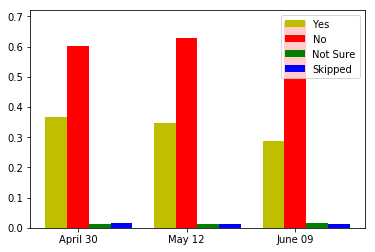

In [72]:
x = [0,1,2]
total_width, n = 0.8, 4
width = total_width / n
 
plt.bar(x, data1, width=width, label='Yes',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, data2, width=width, label='No',tick_label = date,fc = 'r')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, data3, width=width, label='Not Sure',fc = 'g')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, data4, width=width, label='Skipped',fc = 'b')
plt.legend()
plt.show()
